#### Imports

In [21]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

### Images

In [22]:
X_train = pd.read_csv('../data_students/labeled_data/X_train.csv')
X_test = pd.read_csv('../data_students/labeled_data/X_test.csv')

In [23]:
def remove_image_borders(input_folder, output_folder, border_size=5):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            
            width, height = img.size
            
            cropped_img = img.crop((
                border_size,  # Left
                border_size,  # Top
                width - border_size,  # Right
                height - border_size  # Bottom
            ))
            cropped_img.save(os.path.join(output_folder, filename))

img_folder = {
    'Img_train': '../data_students/labeled_data/Img_train',
    'Img_test': '../data_students/labeled_data/Img_test',
}

img_cropped_folder = {
    'Img_train_cropped': '../data_students/labeled_data/Img_train_cropped',
    'Img_test_cropped': '../data_students/labeled_data/Img_test_cropped',
}

for folder, input_path in img_folder.items():
    output_path = img_cropped_folder[folder + '_cropped']
    remove_image_borders(input_path, output_path)
print("All images cropped successfully!")

All images cropped successfully!


In [24]:
def flatten_images_to_set(input_folder):
    flattened_images_set = set()

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            
            img_gray = img.convert('L')  # Convert to grayscale
            img_array = np.array(img_gray).flatten()
            flattened_images_set.add((filename, tuple(img_array)))
    return flattened_images_set

train_images_set = flatten_images_to_set(img_cropped_folder['Img_train_cropped'])
test_images_set = flatten_images_to_set(img_cropped_folder['Img_test_cropped'])

In [25]:
def add_flattened_images_to_dataframe(df, flattened_images_set, img_filename_col='img_filename'):
    flattened_images_dict = {name: values for name, values in flattened_images_set}

    if len(flattened_images_set) > 0:
        num_pixels = len(next(iter(flattened_images_dict.values())))
        new_cols = [f"pixel_{i + 1}" for i in range(num_pixels)]
    else:
        raise ValueError("Flattened images set is empty.")

    pixel_data = df[img_filename_col].map(flattened_images_dict)
    if pixel_data.isna().any():
        raise ValueError("Some filenames in the DataFrame do not match those in the image set.")

    pixel_df = pd.DataFrame(pixel_data.tolist(), columns=new_cols, index=df.index)

    updated_df = pd.concat([df.drop(columns=[img_filename_col]), pixel_df], axis=1)

    return updated_df

X_train = add_flattened_images_to_dataframe(X_train, train_images_set)
X_test = add_flattened_images_to_dataframe(X_test, test_images_set)

X_train.to_csv('../data_students/labeled_data/X_train_with_images.csv', index=False)
X_test.to_csv('../data_students/labeled_data/X_test_with_images.csv', index=False)


#### Data pre-processing

In [26]:
X_train = pd.read_csv('../data_students/labeled_data/X_train_combined.csv')
X_test = pd.read_csv('../data_students/labeled_data/X_test_combined.csv')
y_train = pd.read_csv('../data_students/labeled_data/y_train.csv', header=None).squeeze()
y_test = pd.read_csv('../data_students/labeled_data/y_test.csv', header=None).squeeze()

In [ ]:
label_encoders = LabelEncoder()
X_train['profession'] = label_encoders.fit_transform(X_train['profession'])
X_test['profession'] = label_encoders.transform(X_test['profession'])

categorical_columns = X_train.select_dtypes(include=['object']).columns
satisfaction_order = ['Very low', 'Low', 'Moderate', 'High', 'Very high']
ordinal_encoders = OrdinalEncoder(categories=[satisfaction_order])
for column in categorical_columns:
    X_train[column] = ordinal_encoders.fit_transform(X_train[column].values.reshape(-1, 1))
    X_test[column] = ordinal_encoders.transform(X_test[column].values.reshape(-1, 1))

scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


In [28]:
pixel_cols = [col for col in X_train.columns if col.startswith("pixel_")]
tabular_cols = [col for col in X_train.columns if col not in pixel_cols]

X_train_tabular = X_train[tabular_cols].copy()
X_train_pixels = X_train[pixel_cols].copy()

X_test_tabular = X_test[tabular_cols].copy()
X_test_pixels = X_test[pixel_cols].copy()

X_train_tabular = X_train_tabular.drop(columns=['profession', 'hemoglobin', 'calcium', 'vitamin D'])
X_test_tabular = X_test_tabular.drop(columns=['profession', 'hemoglobin', 'calcium', 'vitamin D'])


#### Feature Selection

In [29]:
def corr(X_train, y_train, k):
    y_train = y_train.squeeze()
    X_train_copy = X_train.copy()
    X_train_copy['target'] = y_train
    corr = X_train_copy.corr(method='pearson')['target'].drop('target')
    abs_corr = corr.abs().sort_values(ascending=False)
    top_features = abs_corr.head(k).index.tolist()
    return top_features

corr(X_train, y_train, 20)

['blood pressure',
 'weight',
 'sarsaparilla',
 'cholesterol',
 'smurfin donuts',
 'age',
 'height',
 'potassium',
 '179',
 'smurfberry liquor',
 '246',
 '247',
 '221',
 '197',
 '63',
 '265',
 '169',
 '92',
 '119',
 '94']

#### Model Selection and Implementation

In [30]:
model = SVR(kernel='rbf')

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'epsilon': [0.01, 0.05, 0.1, 0.5, 1],
    'p': [2, 4, 8, 16, 32, 64, 128]
}

results = []
for p in param_grid['p']:
    top_pixel_features = corr(X_train_pixels, y_train, p)
    X_train_selected = np.hstack([X_train_tabular, X_train_pixels[top_pixel_features]])
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)
    
    svr_param_grid = {
        'C': param_grid['C'],
        'epsilon': param_grid['epsilon']
    }
    grid_search = GridSearchCV(model, svr_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_val_pred = best_model.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    std_val = np.std(y_val - y_val_pred)
    
    results.append({
        'p': p,
        'C': best_params['C'],
        'epsilon': best_params['epsilon'],
        'validation_rmse': rmse_val,
        'validation_std': std_val
    })

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['validation_rmse'].idxmin()]
best_p = best_result['p']
best_C = best_result['C']
best_epsilon = best_result['epsilon']
print(f"\nRMSE= {best_result['validation_rmse']:.4f}, STD= {best_result['validation_std']:.4f}")
print(f"Best Parameters: p={best_p}, C={best_C}, epsilon={best_epsilon}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits

RMSE= 0.0720, STD= 0.0707
Best Parameters: p=2.0, C=0.5, epsilon=0.01


In [31]:
top_pixel_features = corr(X_train_pixels, y_train, int(best_result['p']))

X_train_final = np.hstack([X_train_tabular, X_train_pixels[top_pixel_features]])
X_test_final = np.hstack([X_test_tabular, X_test_pixels[top_pixel_features]])

final_model = SVR(kernel='rbf', C=best_C, epsilon=best_epsilon)
final_model.fit(X_train_final, y_train)

y_test_pred = final_model.predict(X_test_final)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0860


ValueError: cannot reshape array of size 0 into shape (18,18)

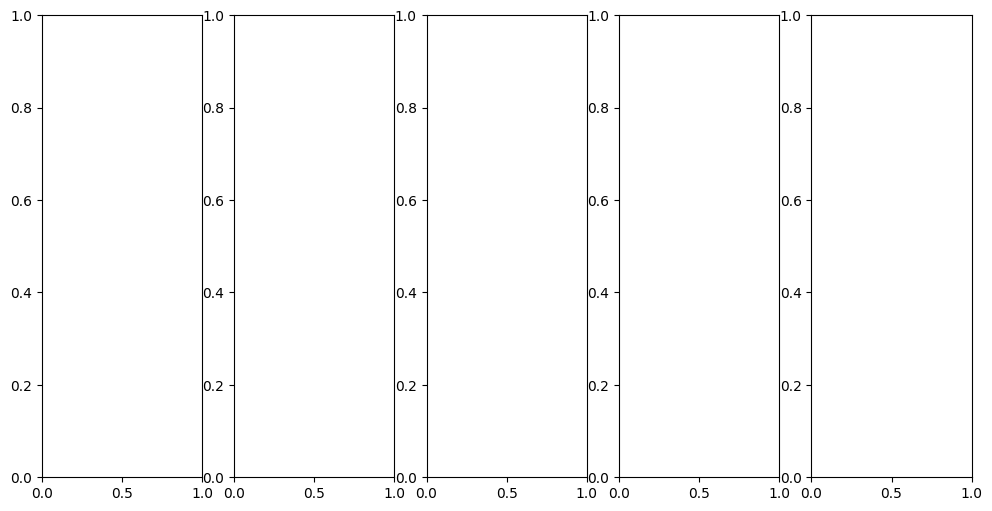

In [32]:
def highlight_pixels_with_overlay(image, selected_pixel_indices, img_shape):
    highlighted_image = image.reshape(img_shape).copy()
    max_value = highlighted_image.max()

    for idx in selected_pixel_indices:
        highlighted_image[idx // img_shape[1], idx % img_shape[1]] = max_value
    
    return highlighted_image

example_image_indices = [0, 1, 2, 3, 4]

selected_pixel_indices = [X_train_pixels.columns.get_loc(feature) for feature in top_pixel_features]

img_shape = (18, 18)

fig, axes = plt.subplots(1, 5, figsize=(12, 6))

for i, idx in enumerate(example_image_indices):
    example_image_flattened = X_test_pixels.iloc[idx].to_numpy()
    highlighted_image = highlight_pixels_with_overlay(example_image_flattened, selected_pixel_indices, img_shape)
    
    ax = axes[i]
    ax.imshow(highlighted_image, cmap='gray')
    ax.set_title(f"Image {idx} - Highlighted")
    ax.axis('off')

plt.tight_layout()
plt.show()
